In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.simplefilter('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 전체 항구 파일 병합(VNHPH, HKHKG, CNHUA)

In [ ]:
import pandas as pd
import glob
import os

# 병합할 폴더 리스트 (항구별 폴더)
folders = ['./dataset/VNHPH', './dataset/CNHUA', './dataset/HKHKG']
merged_dfs = []

for folder in folders:
    port_code = os.path.basename(folder)  # 예: 'VNHPH'

    # 폴더 내 모든 CSV 파일 읽기
    for filepath in glob.glob(os.path.join(folder, '*.csv')):
        df = pd.read_csv(filepath)

        # 선박명 추출 (파일명 기준)
        ship_name = os.path.splitext(os.path.basename(filepath))[0]

        # 선박 ID 및 출발 항구 열 추가
        df['ship_id'] = ship_name
        df['origin_port'] = port_code

        merged_dfs.append(df)

# 전체 데이터프레임 병합
merged_df = pd.concat(merged_dfs, ignore_index=True)

# TIMESTAMP 정렬 (시계열 순서 보장)
# 필요 시 datetime 형식 변환
merged_df['TIMESTAMP'] = pd.to_datetime(merged_df['TIMESTAMP'])
merged_df = merged_df.sort_values('TIMESTAMP').reset_index(drop=True)

# 결과 출력
print(merged_df.head())
print(f"총 병합된 행 수: {len(merged_df)}")

# 저장 -> 파일명 지정 후 저장하면 됨
merged_df.to_csv('merged_all_ships.csv', index=False)

## 데이터 불러오기

In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [150]:
df = pd.read_csv("./dataset/merged_all_ships.csv")

In [152]:
cluster_A_ports = ['VNHPH', 'CNHUA', 'HKHKG']
df['target'] = df['origin_port'].apply(lambda x: 1 if x in cluster_A_ports else 0)

## 함수 생성

In [182]:
def create_offset_sequences(df, features, input_steps=18, target_offset=18):
    X, y = [], []
    for ship_id, group in df.groupby('ship_id'):
        group = group.sort_values('TIMESTAMP')
        values = group[features].to_numpy()
        lat_lon = group[['LAT', 'LON']].to_numpy()

        for i in range(len(values) - input_steps - target_offset):
            X.append(values[i:i+input_steps])
            y.append(lat_lon[i+input_steps+target_offset - 1])  # 6시간 뒤 위치

    return np.array(X), np.array(y)

## 하이퍼파라미터 설정

In [184]:
INPUT_STEPS = 18  # 10분 간격 × 18 = 3시간
TARGET_OFFSET = 18  # 6시간 후
FEATURES = ['COG', 'HEADING', 'LAT', 'LON']
EPOCHS = 20
BATCH_SIZE = 64

## 표준화

In [186]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(INPUT_STEPS, len(FEATURES))),
    Dense(32, activation='relu'),
    Dense(2)  # LAT, LON 예측
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [188]:
X, y = create_offset_sequences(df, FEATURES, INPUT_STEPS, TARGET_OFFSET)

In [190]:
from sklearn.preprocessing import StandardScaler

X_flat = X.reshape(-1, len(FEATURES))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat).reshape(X.shape)

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [194]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 6493.3540 - mae: 66.7100 - val_loss: 2189.4668 - val_mae: 34.6844
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1030.5317 - mae: 21.1224 - val_loss: 31.0566 - val_mae: 4.5813
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 27.7216 - mae: 4.4139 - val_loss: 18.3731 - val_mae: 3.4864
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 15.3047 - mae: 3.1476 - val_loss: 7.4575 - val_mae: 1.9585
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.6931 - mae: 1.7023 - val_loss: 3.5601 - val_mae: 1.1908
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.8623 - mae: 1.0619 - val_loss: 2.3130 - val_mae: 0.8873
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.1336 - mae: 0.7916 - val_loss: 1.7019 - val_mae: 0.6951
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.4810 - mae: 0.6524 - val_loss: 1.2570 - val_mae: 0.6082
Epoch 9/20
184/184 ━━━━━━━━━━━━━

In [196]:
model.save("lstm_position_predictor1.keras")

In [198]:
y_pred = model.predict(X_val)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


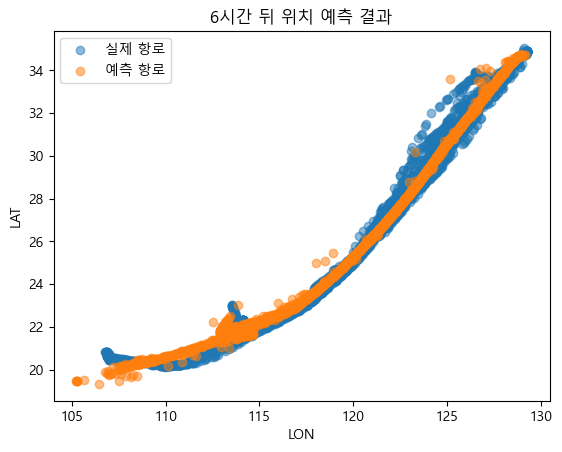

In [202]:
import matplotlib.pyplot as plt

plt.scatter(y_val[:, 1], y_val[:, 0], label='실제 항로', alpha=0.5)  # LON, LAT
plt.scatter(y_pred[:, 1], y_pred[:, 0], label='예측 항로', alpha=0.5)
plt.legend()
plt.xlabel('LON'); plt.ylabel('LAT')
plt.title('6시간 뒤 위치 예측 결과')
plt.show()

# 다른 선박 대입

## 모델 불러오기

In [204]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

In [206]:
model = load_model("lstm_position_predictor1.keras")

In [209]:
df_new = pd.read_csv("./dataset/CNHUA/028690b9-6aba-3401-8d39-d602f2a30d82.csv")  # 예시 경로

In [211]:
FEATURES = ['COG', 'HEADING', 'LAT', 'LON']
df_new = df_new.sort_values('TIMESTAMP')

## 입력 시퀀스 생성

In [213]:
INPUT_STEPS = 18
values = df_new[FEATURES].to_numpy()

In [217]:
input_seq = values[-INPUT_STEPS:]
#가장 최근 18포인트를 이용한 예측

## 스케일링

In [219]:
input_scaled = scaler.transform(input_seq).reshape(1, INPUT_STEPS, len(FEATURES))

In [223]:
pred_latlon = model.predict(input_scaled)
pred_lat, pred_lon = pred_latlon[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [225]:
print(f"예측된 6시간 후 위치: 위도 {pred_lat:.5f}, 경도 {pred_lon:.5f}")

예측된 6시간 후 위치: 위도 23.30650, 경도 116.18169


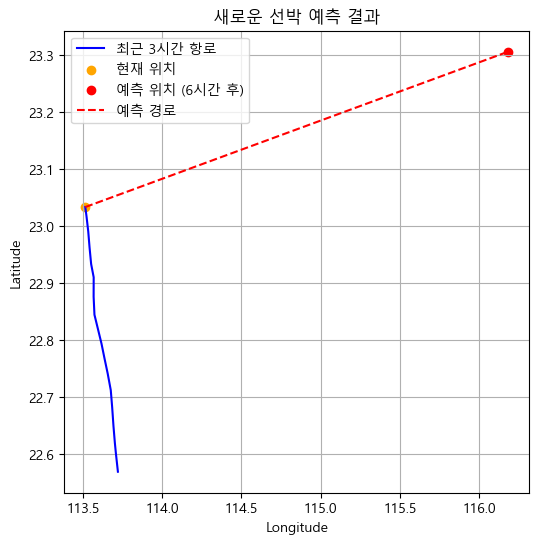

In [229]:
import matplotlib.pyplot as plt

# 현재 위치: 입력 시퀀스 마지막 지점
current_lat, current_lon = input_seq[-1][2], input_seq[-1][3]

# 시각화
plt.figure(figsize=(6, 6))
plt.plot(input_seq[:, 3], input_seq[:, 2], label='최근 3시간 항로', color='blue')  # LON, LAT
plt.scatter(current_lon, current_lat, color='orange', label='현재 위치')
plt.scatter(pred_lon, pred_lat, color='red', label='예측 위치 (6시간 후)')
plt.plot([current_lon, pred_lon], [current_lat, pred_lat], 'r--', label='예측 경로')
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("새로운 선박 예측 결과")
plt.legend()
plt.grid(True)
plt.show()

In [243]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 예측 결과
y_pred = model.predict(X_val)  # shape: (N, 2)

# MAE, RMSE
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print(f"MAE (LAT + LON 평균 오차): {mae:.6f}") # 예측값과 실제값의 절대 오차 평균 → 일반적인 위치 예측 정확도 지표
print(f"RMSE: {rmse:.6f}") # MSE의 제곱근 → 단위가 위치 단위(LAT, LON)와 같아서 해석 쉬움

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAE (LAT + LON 평균 오차): 0.319156
RMSE: 0.767675


In [235]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

# 평균 Haversine 거리 계산
haversine_errors = [
    haversine(lat1, lon1, lat2, lon2)
    for (lat1, lon1), (lat2, lon2) in zip(y_val, y_pred)
]

haversine_mae = np.mean(haversine_errors)
print(f"Haversine MAE (평균 위치 오차, km): {haversine_mae:.2f} km")

Haversine MAE (평균 위치 오차, km): 51.30 km


In [241]:
print(f"MAE (LAT+LON): {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"평균 예측 오차 (Haversine): {haversine_mae:.2f} km")

MAE (LAT+LON): 0.319156
RMSE: 0.767675
평균 예측 오차 (Haversine): 51.30 km


In [245]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, y_pred)
print(f"결정계수 R²: {r2:.4f}")

결정계수 R²: 0.9787


In [257]:
import folium

# 예시: X_val[0]을 사용하여 1개 예측 보기
idx = 0

# 입력 시퀀스 복원
input_seq = X_val[idx].copy()
input_seq_unscaled = scaler.inverse_transform(input_seq)
latlon_seq = input_seq_unscaled[:, 2:4]  # LAT, LON

# 현재 위치
current_lat, current_lon = latlon_seq[-1]

# 예측 위치
pred_lat, pred_lon = y_pred[idx]

# 실제 위치
true_lat, true_lon = y_val[idx]

# 지도 생성
m = folium.Map(location=[current_lat, current_lon], zoom_start=6)

# 파랑 입력 경로
folium.PolyLine(latlon_seq, color='blue', weight=3, popup='입력 항로').add_to(m)

# 주황 현재 위치
folium.Marker(
    location=(current_lat, current_lon),
    icon=folium.Icon(color='orange'),
    popup='현재 위치 (3시간 시점)'
).add_to(m)

# 빨강 예측 위치
folium.Marker(
    location=(pred_lat, pred_lon),
    icon=folium.Icon(color='red', icon='flag'),
    popup='예측 위치 (6시간 후)'
).add_to(m)

# 초록 실제 위치
folium.Marker(
    location=(true_lat, true_lon),
    icon=folium.Icon(color='green'),
    popup='실제 위치 (6시간 후)'
).add_to(m)

# 초록 <-> 빨강 예측 vs 실제 오차 선
folium.PolyLine(
    [(pred_lat, pred_lon), (true_lat, true_lon)],
    color='green',
    dash_array='5, 10',
    weight=2,
    popup='예측 오차'
).add_to(m)

# 지도 저장
display(m)

In [255]:
import pandas as pd
import numpy as np
import folium
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# 1. 모델 및 데이터 불러오기
model = load_model("lstm_position_predictor1.keras")
df = pd.read_csv("./dataset/merged_all_ships.csv")

# 2. 파라미터 설정
INPUT_STEPS = 18
TARGET_OFFSET = 18
FEATURES = ['COG', 'HEADING', 'LAT', 'LON']

# 3. 시퀀스 생성 함수
def create_offset_sequences(df, features, input_steps=18, target_offset=18):
    X, y = [], []
    for ship_id, group in df.groupby('VSL_ID'):
        group = group.sort_values('TIMESTAMP')
        values = group[features].to_numpy()
        latlon = group[['LAT', 'LON']].to_numpy()
        for i in range(len(group) - input_steps - target_offset):
            X.append(values[i:i+input_steps])
            y.append(latlon[i+input_steps+target_offset-1])
    return np.array(X), np.array(y)

# 4. 시퀀스 생성 및 정규화
X, y = create_offset_sequences(df, FEATURES, INPUT_STEPS, TARGET_OFFSET)
scaler = StandardScaler()
X_flat = X.reshape(-1, len(FEATURES))
X_scaled = scaler.fit_transform(X_flat).reshape(X.shape)

# 5. 예측
y_pred = model.predict(X_scaled)

# 6. 특정 시퀀스 시각화
idx = 0
input_seq = X_scaled[idx]
input_seq_unscaled = scaler.inverse_transform(input_seq)
latlon_seq = input_seq_unscaled[:, 2:4]
latlon_path = [(lat, lon) for lat, lon in latlon_seq]

current_lat, current_lon = latlon_path[-1]
pred_lat, pred_lon = y_pred[idx]
true_lat, true_lon = y[idx]

# 7. folium 지도 시각화
m = folium.Map(location=[current_lat, current_lon], zoom_start=6)
folium.PolyLine(latlon_path, color='blue', weight=3, popup='입력 항로').add_to(m)
folium.Marker((current_lat, current_lon), icon=folium.Icon(color='orange'), popup='현재 위치 (3시간)').add_to(m)
folium.Marker((pred_lat, pred_lon), icon=folium.Icon(color='red', icon='flag'), popup='예측 위치 (6시간 후)').add_to(m)
folium.Marker((true_lat, true_lon), icon=folium.Icon(color='green'), popup='실제 위치 (6시간 후)').add_to(m)
folium.PolyLine([(pred_lat, pred_lon), (true_lat, true_lon)], color='green', dash_array='5, 10', weight=2, popup='예측 vs 실제').add_to(m)

# 8. 지도 저장 및 확인
display(m)

458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
